<a href="https://colab.research.google.com/github/czymaraclass/TopicModelling/blob/main/topic_models_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic models in R

## Install packages

In [ ]:
# Packages that we will need for this exercise
packages <- c("quanteda", "stm", "BTM", "keyATM",
              "textplot", "igraph", "ggraph", "concaveman")

install.packages(packages)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘iterators’, ‘listenv’, ‘parallelly’, ‘e1071’, ‘wk’, ‘ISOcodes’, ‘foreach’, ‘shape’, ‘future’, ‘globals’, ‘mvtnorm’, ‘tweenr’, ‘polyclip’, ‘gridExtra’, ‘classInt’, ‘s2’, ‘units’, ‘fastmatch’, ‘Rcpp’, ‘RcppParallel’, ‘SnowballC’, ‘stopwords’, ‘RcppArmadillo’, ‘glmnet’, ‘lda’, ‘matrixStats’, ‘quadprog’, ‘slam’, ‘future.apply’, ‘ggrepel’, ‘matrixNormal’, ‘pgdraw’, ‘RcppEigen’, ‘ggforce’, ‘viridis’, ‘tidygraph’, ‘graphlayouts’, ‘V8’, ‘sf’


Warning message in install.packages(packages):
“installation of package ‘s2’ had non-zero exit status”


## Data: AG news articles collection

[AG data set](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) as provided by the [textdata](https://github.com/EmilHvitfeldt/textdata) package.

In [ ]:
library(dplyr)
library(magrittr)

newspaper_data <- read.csv("https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv", header = F)

# draw a 10 percent random sample to speed things up
set.seed(1337)
newspaper_data <- newspaper_data[sample(1:nrow(newspaper_data), size=nrow(newspaper_data)*.1), ]

# prepare
newspaper_data$title <- newspaper_data$V2
newspaper_data$description <- newspaper_data$V3

newspaper_data %<>%
  mutate(class = recode(V1,
                        `1` = "World",
                        `2` = "Sports",
                        `3` = "Business",
                        `4` = "Sci/Tech"))

table(newspaper_data$class)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union





Business Sci/Tech   Sports    World 
    2975     2995     3047     2983 

What does the data look like?

In [ ]:
head(newspaper_data[4:6])

ERROR: ignored

## Preprocessing the data

Remeber, we want data in a document-feature-matrix, where the texts (documents) are in the rows and the terms (features) in the columns.

In [ ]:
library(quanteda)

corpus <- corpus(as.character(newspaper_data$description),
                 docvars = data.frame(class = newspaper_data$class
                 ))

toks <- tokens(corpus, remove_punct = T,
               remove_numbers = T,
               remove_symbols = T,
               remove_separators = T,
               split_hyphens = T,
               remove_url = T,
               include_docvars = T)

toks <- tokens_remove(toks, stopwords(source = "stopwords-iso"), case_insensitive = TRUE)

toks <- tokens_wordstem(toks)

# Create document feature matrix
newspapers_dfm <- dfm(toks)

newspapers_dfm <- dfm_trim(newspapers_dfm,
                           max_docfreq = 0.20,
                           min_docfreq = 0.001,
                           docfreq_type = "prop")

newspapers_dfm <- newspapers_dfm[!rowSums(newspapers_dfm) == 0, ] # remove empty rows

nrow(newspapers_dfm)
ncol(newspapers_dfm)

Package version: 3.3.1
Unicode version: 14.0
ICU version: 70.1

Parallel computing: 2 of 2 threads used.

See https://quanteda.io for tutorials and examples.



[1] 12000

[1] 2748

## Running the topic model

Here, we (arbitrarily) chose a model with 100 topics.

stm v1.3.6.1 successfully loaded. See ?stm for help. 
 Papers, resources, and other materials at structuraltopicmodel.com



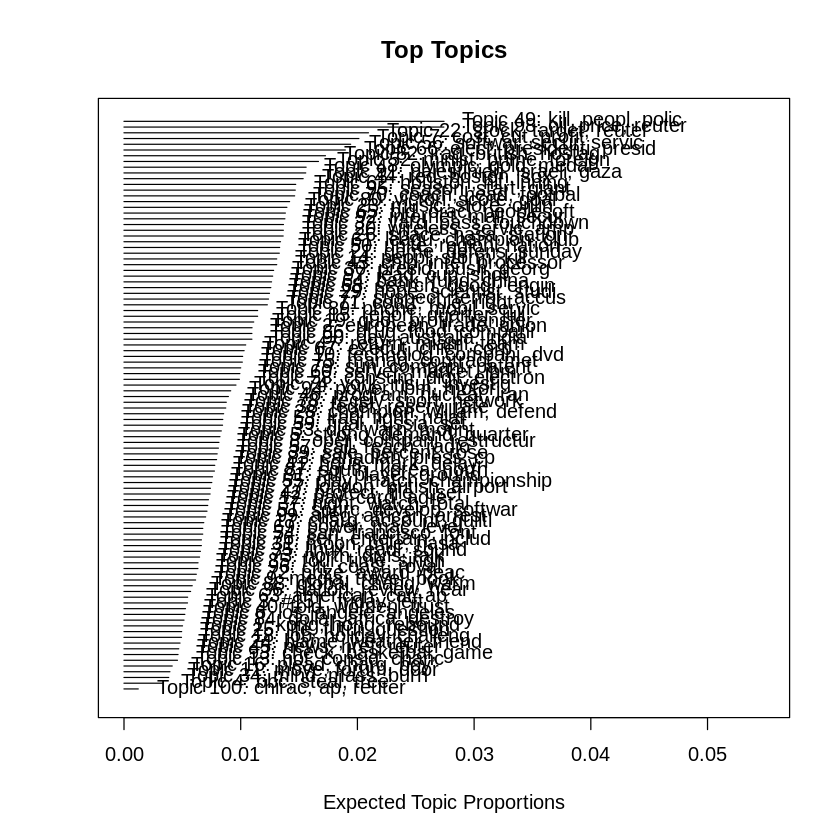

In [ ]:
library(stm)

# number of topics
k <- 100

set.seed(1337)
news_topics <- stm(newspapers_dfm,
                     K = k,
                     prevalence = ~class,
                     max.em.its = 50,
                     verbose = FALSE
                     )

plot(news_topics)

In [ ]:
summary(news_topics)

A topic model with 100 topics, 12000 documents and a 2748 word dictionary.


Topic 1 Top Words:
 	 Highest Prob: kong, hong, rebound, form, fast, suggest, articl 
 	 FREX: kong, hong, rebound, articl, fast, round, form 
 	 Lift: articl, kong, hong, rebound, round, devil, pennsylvania 
 	 Score: articl, kong, hong, rebound, round, form, fast 
Topic 2 Top Words:
 	 Highest Prob: european, trade, union, eu, talk, asian, organiz 
 	 FREX: european, organiz, eu, union, trade, airbus, sanction 
 	 Lift: accord, airbus, subsidi, eu, membership, brussels, european 
 	 Score: accord, european, union, trade, eu, airbus, sanction 
Topic 3 Top Words:
 	 Highest Prob: #151, friday, left, convent, revolut, heard, colorado 
 	 FREX: #151, revolut, heard, clinton, upset, surgeri, convent 
 	 Lift: revolut, heard, #151, clinton, ross, iowa, tailback 
 	 Score: revolut, #151, heard, clinton, upset, left, colorado 
Topic 4 Top Words:
 	 Highest Prob: bbc, steal, tree, famili, armi, spread, pose 
 	 FREX: bbc, steal, tree, spread, daniel, pose, famili 
 	 Lift: steal, bbc, daniel,

## Test for differences between genres

Now we know which topics occur. But how does this differ accross the four larger genre categories provided in the original data set?

First, we need to run the model that estimates the relationships between topics and covariates.

In [ ]:
genre_diff <- estimateEffect(1:k ~ class,
                              news_topics,
                              meta = newspapers_dfm@docvars
                              )

Now we can check how each topic is associated with each genre. For example, which genre discusses the terrorism topic (49) most?

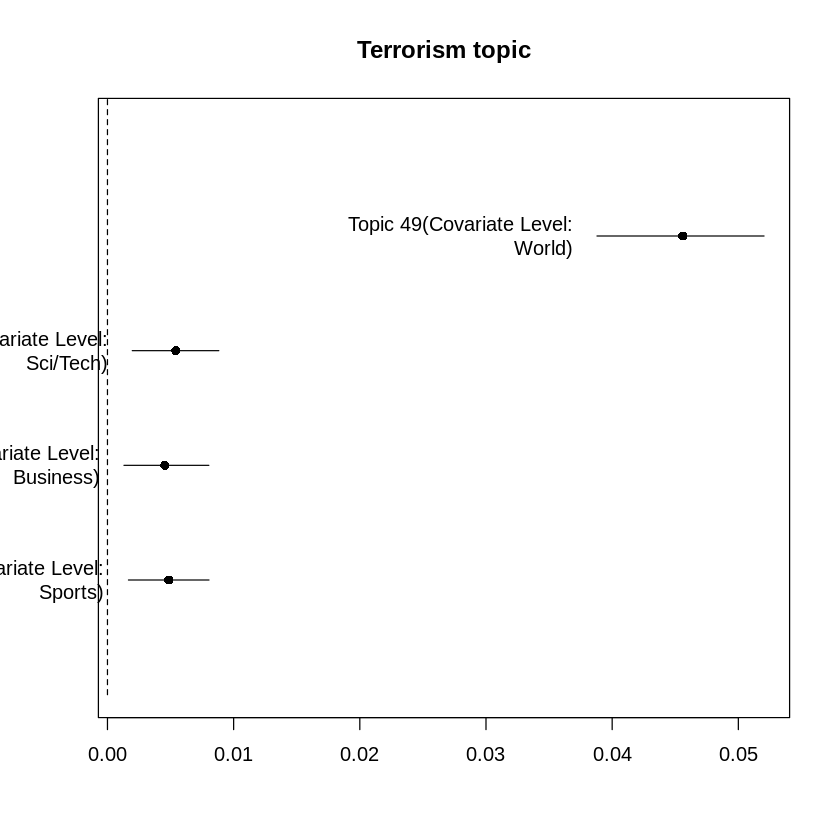

In [ ]:
plot(genre_diff,
     topics = 49,
     covariate = "class",
     method = "pointestimate",
     main = "Terrorism topic"
     )

Which articles are examples for this topic?

In [ ]:
findThoughts(news_topics, texts = newspaper_data$title, n = 10, topics = 49)


 Topic 49: 
 	 Insurgents Target Iraqi Police; 59 Dead
 	Car Bombers Strike Near Green Zone, 7 Dead
 	Car Bomb in Iraq Kills Two, Wounds 60
 	6 Civilians, 17 Insurgents Killed in Iraq Violence
 	Iraq Rebels Hit Back Amid Falluja Battles (Reuters)
 	Bomb Blasts in Baghdad Kill at Least 16 -Police
 	Eight US Marines among 24 killed in Iraq
 	Car bombs claim a dozen lives in Iraq
 	Two killed in Baghdad attacks
 	Car bombers kill seven in Iraq

# Alternatives to STM

## Biterm Topic Models

Biterm Topic Models (BTM) find topics in collections of short texts. How long are the texts on average?

In [ ]:
# actual texts
paste(print("Mean number of characters of texts:"), round(mean(nchar(newspaper_data$description))), print("; standard deviation:"), round(sd(nchar(newspaper_data$description))))

# headlines
paste(print("Mean number of characters of headlines:"), round(mean(nchar(newspaper_data$title))), print("; standard deviation:"), round(sd(nchar(newspaper_data$title))))

[1] "Mean number of characters of texts:"
[1] "; standard deviation:"


[1] "Mean number of characters of texts: 194 ; standard deviation: 64"

[1] "Mean number of characters of headlines:"
[1] "; standard deviation:"


[1] "Mean number of characters of headlines: 42 ; standard deviation: 14"

BTM is a word co-occurrence based topic model that learns topics by modeling word-word cooccurrences patterns which are called biterms ([vignette](https://cran.r-project.org/web/packages/BTM/BTM.pdf)). First, we need to reshape the data.

In [ ]:
library(tidyr)

corpus_title <- corpus(as.character(newspaper_data$title),
                 docvars = data.frame(class = newspaper_data$class
                 ))

toks_title <- tokens(corpus_title, remove_punct = T,
               remove_numbers = T,
               remove_symbols = T,
               remove_separators = T,
               split_hyphens = T,
               remove_url = T,
               include_docvars = T)

toks_title <- tokens_remove(toks_title, stopwords(source = "stopwords-iso"), case_insensitive = TRUE)
toks_title <- tokens_wordstem(toks_title)

dfm_title <- dfm(toks_title)


# convert to data.frame
toks_2 <- convert(dfm_title, to = "data.frame")

toks_2 <- toks_2 %>%
  pivot_longer(cols = c(!doc_id), names_to = "tokens")


toks_2 <- toks_2[toks_2$value > 0, ]


toks_2 <- toks_2[, c("doc_id", "tokens")]

head(toks_2)

doc_id,tokens
<chr>,<chr>
text1,mobil
text1,game
text1,take
text1,india
text2,ape
text2,swinger


Run the model.

In [ ]:
library(BTM)

set.seed(1234)
bi_topics  <- BTM(toks_2,
                  k = k,
                  background = TRUE # first topic is set to a background topic, can be used to filter out common words
                  )

terms(bi_topics, top_n = 10)

,token,probability
,<chr>,<dbl>
1,ap,0.007940252
2,assault,0.007940252
3,australian,0.007940252
4,bank,0.007940252
5,brace,0.007940252
6,budget,0.007940252
7,bush,0.007940252
8,charg,0.007940252
9,clash,0.007940252


Plot the results:

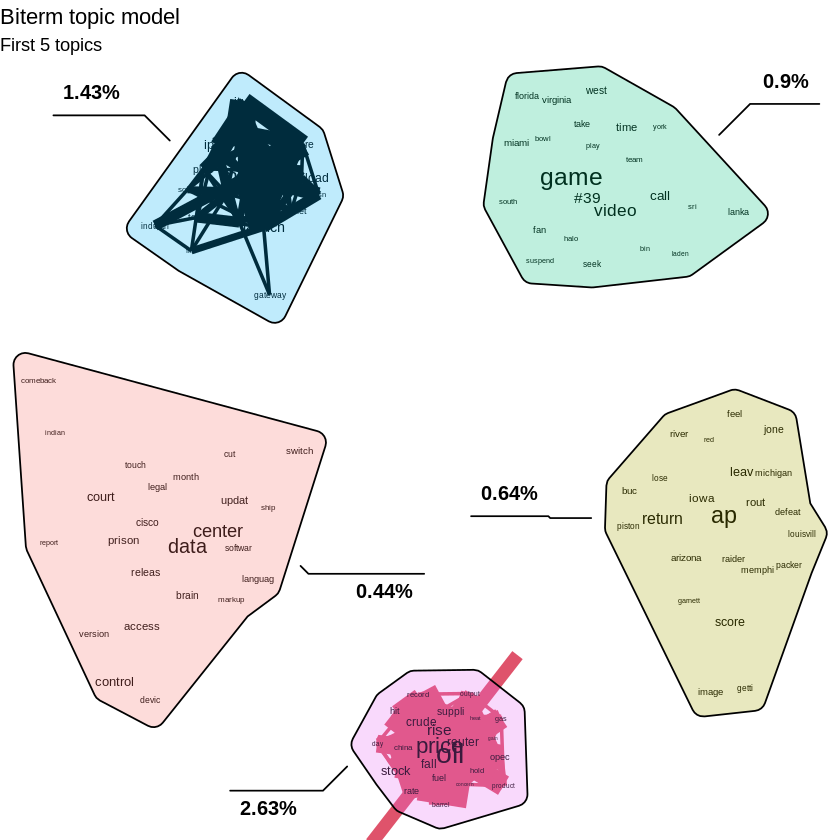

In [ ]:
library(textplot)

# Plot first 5 topics (excluding the garbage one) with 25 terms and labelled by the proportion
plot(bi_topics, which = 2:6, subtitle = "First 5 topics",
    labels = paste(round(bi_topics$theta*100, 2), "%", sep = ""), top_n = 25)

In the plot above, word size shows how common a word is in a topic (smaller words have a lower probability (theta) of appearing in a topic).

The lines within the topics resemble tie strength between words (thicker lines indicate stronger correlations between terms).

## Keyword Assisted Topic Models

An important advantage of the proposed keyword-assisted topic
model (keyATM) is that the specification of keywords requires researchers to label topics prior to fitting a model to the data. ([Eshima et al. 2023](https://onlinelibrary.wiley.com/doi/full/10.1111/ajps.12779))

In [ ]:
library(keyATM)

keyATM_docs <- keyATM_read(texts = newspapers_dfm)

keywords <- list(
  business  = c("sale", "bank", "profit"),
  sci       = c("moon", "nasa", "space"),
  sport     = c("olympic", "gold", "medal"),
  world     = c("kill", "bomb", "attack")
  )


keyATM 0.5.0 successfully loaded.
 Papers, examples, resources, and other materials are at
 https://keyatm.github.io/keyATM/

ℹ Using quanteda dfm.



Run the model.

In [ ]:
key_topics <- keyATM(
  docs              = keyATM_docs,  # text input
  no_keyword_topics = k-4,          # number of topics without keyword topics
  keywords          = keywords,     # keywords
  model             = "base",       # select the model
  options           = list(seed = 1337)
  )

top_words(key_topics)

⠙ Initializing the model

Warning message:
“A keyword is pruned because it does not appear in the documents: saturn”
✔ Initializing the model s]



⠙ Fitting the model: 1500 iterations

Fitting the model ■                                  0% |  ETA: ?

Fitting the model ■                                  0% |  ETA:  1h

Fitting the model ■                                  0% |  ETA:  1h

Fitting the model ■                                  0% |  ETA:  1h

Fitting the model ■                                  0% |  ETA:  1h

Fitting the model ■                                  0% |  ETA:  1h

Fitting the model ■                                  0% |  ETA:  1h

Fitting the model ■                                  1% |  ETA:  1h

Fitting the model ■                                  1% |  ETA:  1h

Fitting the model ■                                  1% |  ETA:  1h

Fitting the model ■                                  1% |  ETA:  1h

Fitting the model ■                                  1% |

1_business,2_sci,3_sport,4_world,Other_1,Other_2,Other_3,Other_4,Other_5,Other_6,⋯,Other_87,Other_88,Other_89,Other_90,Other_91,Other_92,Other_93,Other_94,Other_95,Other_96
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
profit [✓],space [✓],#39,kill [✓],oil,continu,#39,rate,ap,ibm,⋯,#39,ap,sox,servic,record,#39,oil,#39,#39,phone
#39,nasa [✓],gold [✓],#39,cut,injuri,hunt,martha,wood,recal,⋯,tax,red,red,merger,game,eu,#39,game,grand,internet
sale [✓],#39,ap,ap,price,lion,sri,stewart,center,comput,⋯,ap,sox,deal,voip,speed,search,wall,reuter,strike,game
share [✓],moon [✓],win,iraq,opec,deal,lanka,question,project,power,⋯,file,peoplesoft,angel,amp,video,turkey,price,nhl,theft,quot
rise,ap,olympic [✓],bomb [✓],fee,road,drug,hike,quit,mortgag,⋯,jail,seri,#39,talk,set,reuter,stock,boss,auto,mobil
stock,launch,bid,reuter,food,week,japan,prison,game,week,⋯,ebay,oracl,extend,deal,bankruptci,boe,street,real,win,video
oil,station,medal [✓],palestinian,boost,crisi,china,reuter,softwar,stake,⋯,sentenc,cardin,sign,phone,break,engine,chang,season,charg,longhorn
reuter,flight,victori,attack [✓],product,sign,reuter,cup,window,fall,⋯,compani,defeat,blast,firm,file,airbus,iraq,player,san,#39
ap,shuttl,field,israeli,trade,yanke,ban,fed,data,talk,⋯,offer,takeov,yanke,sprint,ibm,execut,hostag,suspend,arsenal,risk


How often do these topics appear?

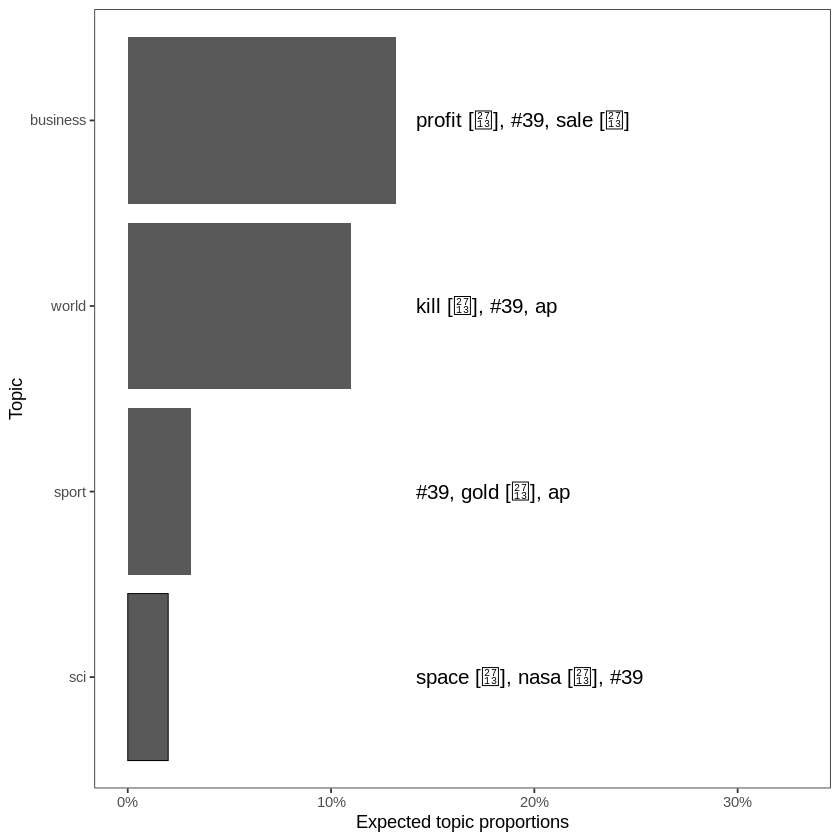

In [ ]:
plot_topicprop(key_topics, show_topic = 1:4)